# Overview

A client wants to purchase a home in Westchester county and wants to ensure their home is a good investment. They measure that by ROI they will get in 5 years. Their budget is $500K. Our firm is asked to recommend 5 zipcodes in Westchester county that would be good options.

# Business Understanding

- Objective: Identify five ZIP codes in Westchester County where a client can purchase a home within a $500,000 budget, aiming for optimal Return on Investment (ROI) over a 5-year period.

- Stakeholder: A prospective homebuyer seeking a property in Westchester County that not only fits within their financial constraints but also promises substantial appreciation.

- Problem: Determining which ZIP codes in Westchester County offer homes priced at or below $500,000 and are projected to yield the highest ROI over a 5-year span.

Key Questions
1. Which ZIP codes in Westchester County have homes available within the $500,000 budget?
2. What are the historical and projected real estate trends in these ZIP codes?
3. Which of these areas are anticipated to provide the highest ROI over the next 10 years?

Success Metric: ROI (Return on Investment) over a 5-year period.

Model Evaluation Metric: AIC

# Data Understanding

Our data set contains historical home prices across the US from 1996 to 2018.
* RegionID
* RegionName
* City
* State	Metro
* CountyName
* SizeRank
* Dates and their median home prices

1. Data Sources and Suitability
* Data Source: The dataset contains historical home prices from 1996 to 2018 for various zip codes in Westchester County. It includes monthly price data, along with location identifiers such as zip codes, city, and county names.
Suitability: This data is well-suited for the project because it offers a long historical time series, allowing for the identification of trends and seasonality—essential for reliable real estate price forecasting. The zip code granularity also aligns with the project's goal of pinpointing the top 5 zip codes for home investment.
* Dataset Size: The dataset contains 14,723 rows and 272 columns.

2. Feature Justification
* RegionName (Zip Code): Used to segment price data by location—crucial for identifying high-ROI zip codes.
* City, State, County: Provides geographic context.
* Monthly Price Columns: These serve as the core time series data for price forecasting.
* Metro: Helpful for capturing broader economic trends that might influence local price changes.

3. Data Limitations
* Single Data Source: The data comes solely from Zillow, which introduces a risk of bias. Zillow may adjust or estimate home prices in ways that align with their business goals, potentially affecting the objectivity of the data.
* Timeframe: Data stops at 2018—limiting how recent trends (like post-2020 shifts) impact price predictions.
* Inflation Adjustments: Prices are nominal; without inflation adjustments, real ROI might be skewed.

In [1]:
# install packages
!pip install pmdarima
!pip install folium


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
import pmdarima as pm
import statsmodels.api as sm
import folium
%matplotlib inline

import warnings
from pandas.errors import SettingWithCopyWarning
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

# Suppress FutureWarnings, ValueWarnings, DeprecationWarnings, and ConvergenceWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

In [3]:
# Load the data and preview data
df=pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Filtering for Westchester
Since our client is only interested in purchasing a house in Westchester county we will filter the data to only include those zipcodes.

In [4]:
# Since we know we are only looking in Westchester county, let's filter our dataset for that

westchester_df = df[df['CountyName'] == 'Westchester']
westchester_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1049800,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,531000,536300,538700,537400,536400,537200,539100,537700,533000,530900
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800


In [5]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [6]:
df.shape

(14723, 272)

In [7]:
# Basic EDA: summary statistics, data types, and city distribution
print("Basic Statistics (non-date columns):")
non_date_columns = ['RegionID', 'RegionName', 'SizeRank']
print(westchester_df[non_date_columns].describe())

print("\nData Information:")
print(westchester_df.info())

print("\nTop 10 Cities by Frequency:")
print(westchester_df['City'].value_counts().head(10))


Basic Statistics (non-date columns):
           RegionID    RegionName      SizeRank
count     61.000000     61.000000     61.000000
mean   61866.573770  10593.065574   7988.196721
std       27.504217     83.122975   3416.616420
min    61817.000000  10501.000000    275.000000
25%    61843.000000  10533.000000   5843.000000
50%    61867.000000  10570.000000   8312.000000
75%    61891.000000  10605.000000  10334.000000
max    61909.000000  10805.000000  14621.000000

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 274 to 14620
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 130.1+ KB
None

Top 10 Cities by Frequency:
City
Yonkers            6
Somers             4
White Plains       3
New Rochelle       3
Mount Vernon       3
Lewisboro          2
Bedford            2
Cortlandt Manor    2
Greenburgh         2
Eastchester        2
Name: count, dtype: int64


# Data Preparation
## Overview of Steps
1. Filter for Home Prices under $500K
2. Check for Null values
3. Rename "RegionName" to "Zipcode"
4. Filter out data before 2009
5. Melt data frame to transform from long to wide format

In [63]:
# How many zip codes are in each city
zipcode_counts = westchester_df.groupby('City')['RegionName'].nunique().reset_index()
zipcode_counts.columns = ['City', 'Num_Zipcodes']
print(zipcode_counts)

                  City  Num_Zipcodes
0              Ardsley             1
1              Bedford             2
2     Briarcliff Manor             1
3            Chappaqua             2
4      Cortlandt Manor             2
5     Croton-on-Hudson             1
6          Dobbs Ferry             1
7          Eastchester             2
8             Elmsford             1
9       Goldens Bridge             1
10          Greenburgh             2
11            Harrison             1
12           Hartsdale             1
13  Hastings on Hudson             1
14           Hawthorne             1
15           Irvington             1
16           Larchmont             1
17           Lewisboro             2
18          Mamaroneck             1
19         Mount Kisco             1
20        Mount Vernon             3
21        New Rochelle             3
22        North Castle             1
23         North Salem             1
24            Ossining             1
25           Peekskill             1
2

### Filtering for Home Prices under $500K

In [9]:
filtered_df = westchester_df[westchester_df['2018-04'] <=500_000]

# Display the filtered DataFrame
filtered_df.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,425400,430500,435600,439500,440800,442300,444800,446700,449200,452600
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,417400,419600,420200,419700,417200,413800,412000,412100,414400,416900
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,444400,447800,450600,450400,447500,445100,444500,444600,445400,445800
4579,61865,10566,Peekskill,NY,New York,Westchester,4580,143200.0,143500.0,143700.0,...,272300,272800,271800,270200,268500,269400,271800,274400,278400,283400
5849,61897,10703,Yonkers,NY,New York,Westchester,5850,163800.0,163500.0,163200.0,...,411200,413400,415400,417000,418400,419200,419900,419400,420300,422800
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,216500.0,217100.0,217800.0,...,496500,495600,498100,498900,493500,488200,486400,488500,494200,499100
6617,61866,10567,Cortlandt Manor,NY,New York,Westchester,6618,181200.0,180800.0,180300.0,...,374200,373600,375400,376600,375900,376400,378600,380600,382700,385100


In [10]:
zipcode_counts = filtered_df.groupby('City')['RegionName'].nunique().reset_index()
zipcode_counts.columns = ['City', 'Num_Zipcodes']
print(zipcode_counts)

              City  Num_Zipcodes
0  Cortlandt Manor             2
1         Elmsford             1
2   Goldens Bridge             1
3       Greenburgh             1
4     Mount Vernon             2
5         Ossining             1
6        Peekskill             1
7           Somers             2
8          Yonkers             4
9         Yorktown             2


In [11]:
# Check for null values
filtered_df.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [12]:
# Convert dates to datetime objects
def get_datetimes(df):
    """
    Takes a dataframe:
    Returns only those column names that can be converted into datetime objects
    as datetime objects.
    """
    date_columns = [col for col in df.columns if pd.to_datetime(col, format='%Y-%m', errors='coerce') is not pd.NaT]
    return pd.to_datetime(date_columns, format='%Y-%m')

# Run the function
datetime_columns = get_datetimes(filtered_df)
print(datetime_columns)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)


In [13]:
# rename columns
filtered_df = filtered_df.rename(columns={'RegionName': 'Zipcode'})
filtered_df

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,425400,430500,435600,439500,440800,442300,444800,446700,449200,452600
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,417400,419600,420200,419700,417200,413800,412000,412100,414400,416900
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,444400,447800,450600,450400,447500,445100,444500,444600,445400,445800
4579,61865,10566,Peekskill,NY,New York,Westchester,4580,143200.0,143500.0,143700.0,...,272300,272800,271800,270200,268500,269400,271800,274400,278400,283400
5849,61897,10703,Yonkers,NY,New York,Westchester,5850,163800.0,163500.0,163200.0,...,411200,413400,415400,417000,418400,419200,419900,419400,420300,422800
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,216500.0,217100.0,217800.0,...,496500,495600,498100,498900,493500,488200,486400,488500,494200,499100
6617,61866,10567,Cortlandt Manor,NY,New York,Westchester,6618,181200.0,180800.0,180300.0,...,374200,373600,375400,376600,375900,376400,378600,380600,382700,385100


### Visualizing Home Prices over time in each zipcode

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_14292\2553242710.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melted_df['time'] = pd.to_datetime(melted_df['time'], errors='coerce')


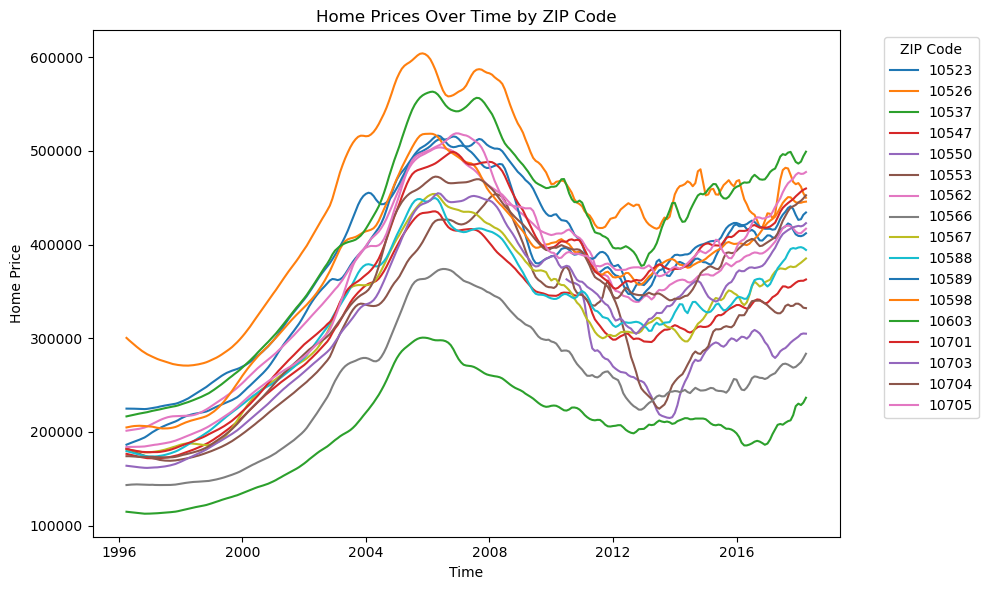

In [14]:
# Reshape the DataFrame
melted_df = pd.melt(filtered_df, id_vars=['Zipcode', 'City', 'State', 'Metro', 'CountyName'], 
                    var_name='time', value_name='value')

# Convert 'time' to datetime
melted_df['time'] = pd.to_datetime(melted_df['time'], errors='coerce')

# Plot the data
plt.figure(figsize=(10, 6))
for zipcode, group in melted_df.groupby('Zipcode'):
    plt.plot(group['time'], group['value'], label=str(zipcode))

plt.xlabel('Time')
plt.ylabel('Home Price')
plt.title('Home Prices Over Time by ZIP Code')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Filter out dates before 2009
Due to the housing market crash in 2008, all of our zipcodes saw a drastic dip during that time and the following years. To filter out some of that noise we will filter out all dates and prices before 2009.

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_14292\2747997783.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melted_df['time'] = pd.to_datetime(melted_df['time'], errors='coerce')


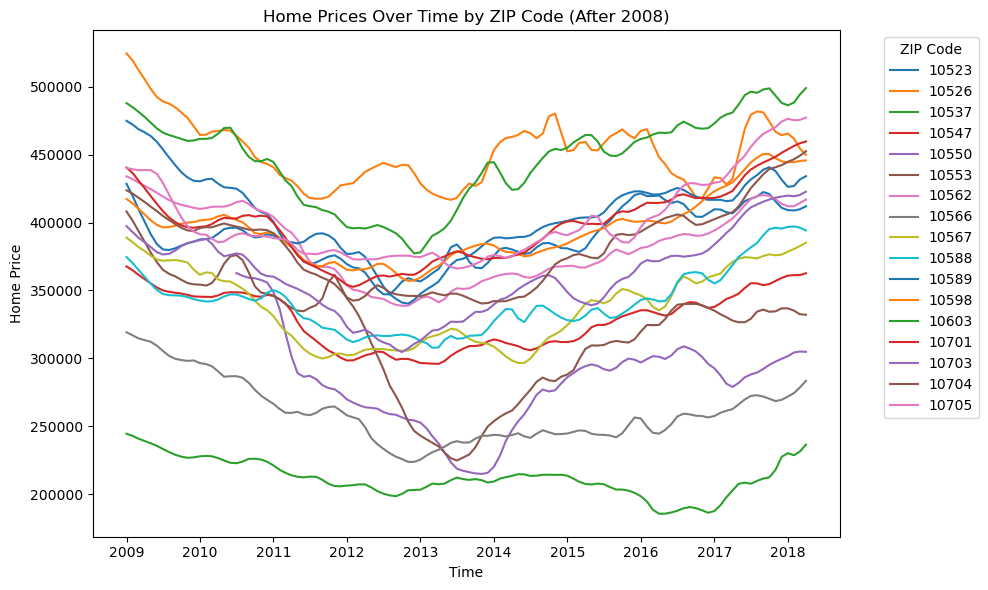

In [15]:
# Reshape the DataFrame
melted_df = pd.melt(filtered_df, 
                    id_vars=['Zipcode', 'City', 'State', 'Metro', 'CountyName'], 
                    var_name='time', 
                    value_name='value')

# Convert 'time' to datetime
melted_df['time'] = pd.to_datetime(melted_df['time'], errors='coerce')

# Filter for dates after 2008 (i.e., from 2009 onward)
melted_df = melted_df[melted_df['time'] >= pd.to_datetime('2009-01-01')]

# Plot the data
plt.figure(figsize=(10, 6))
for zipcode, group in melted_df.groupby('Zipcode'):
    plt.plot(group['time'], group['value'], label=str(zipcode))

plt.xlabel('Time')
plt.ylabel('Home Price')
plt.title('Home Prices Over Time by ZIP Code (After 2008)')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

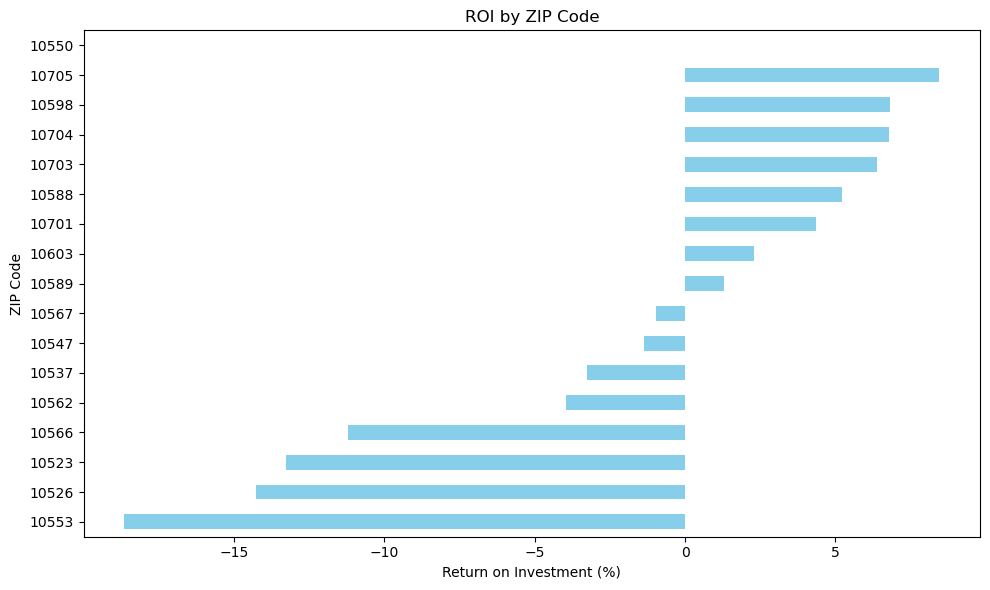

In [16]:
# Calculate ROI
pivot_df = melted_df.pivot_table(index='Zipcode', columns='time', values='value')
pivot_df['ROI'] = (pivot_df.iloc[:, -1] - pivot_df.iloc[:, 0]) / pivot_df.iloc[:, 0] * 100

plt.figure(figsize=(10, 6))
pivot_df['ROI'].sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Return on Investment (%)')
plt.ylabel('ZIP Code')
plt.title('ROI by ZIP Code')
plt.tight_layout()
plt.show()

### Reshape data from wide to long format (melt function)

In [64]:
def melt_data(df):
    '''
    Transforms the input DataFrame by melting date columns into a long format, converting dates to datetime,
    and calculating the average home price by time.
    '''
    # Select only the date columns for melting
    date_columns = [col for col in df.columns if isinstance(col, str) and '-' in col]
    melted = pd.melt(df, id_vars=['Zipcode', 'City', 'State', 'Metro', 'CountyName'], value_vars=date_columns, var_name='time', value_name='HomePrice')
    
    # Convert the 'time' column to datetime
    melted['time'] = pd.to_datetime(melted['time'], errors='coerce')
    
    # Drop rows where 'time' could not be converted
    melted = melted.dropna(subset=['time'])
    
    # Group by 'time' and calculate the mean 'HomePrice'
    result = melted.groupby('time')['HomePrice'].mean().reset_index()
    
    return result

### Choosing a zipcode to create our model
We willuse 10704 as an example zip code to create our model.

In [18]:
# Filter for 10704
filtered_df_10704=filtered_df[filtered_df['Zipcode']==10704]

In [19]:
ts_10704=melt_data(filtered_df_10704)
ts_10704

,time,HomePrice
0,1996-04-01,174000.0
1,1996-05-01,174000.0
2,1996-06-01,173800.0
3,1996-07-01,173700.0
4,1996-08-01,173500.0
...,...,...
260,2017-12-01,442300.0
261,2018-01-01,444800.0
262,2018-02-01,446700.0
263,2018-03-01,449200.0


In [20]:
# Assuming your DataFrame is named df
ts_10704['time'] = pd.to_datetime(ts_10704['time'], errors='coerce')

# Filter for dates after 2008 (starting from January 1, 2009)
ts_10704 = ts_10704[ts_10704['time'] >= pd.to_datetime('2009-01-01')]

# Set the 'time' column as the index
ts_10704.set_index('time', inplace=True)

In [21]:
ts_10704

,HomePrice
time,
2009-01-01,423800.0
2009-02-01,421300.0
2009-03-01,418400.0
2009-04-01,415200.0
2009-05-01,411800.0
...,...
2017-12-01,442300.0
2018-01-01,444800.0
2018-02-01,446700.0


### Visualize home prices in zipcode 10704

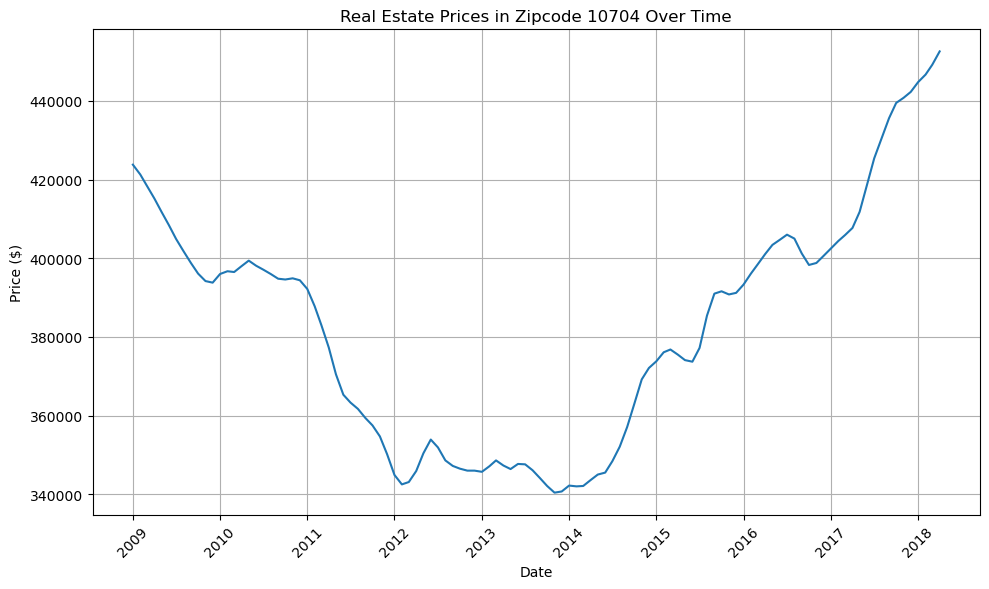

In [22]:
# visualize home prices in 10704
plt.figure(figsize=(10, 6))
plt.plot(ts_10704)
plt.title('Real Estate Prices in Zipcode 10704 Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
ts_10704

,HomePrice
time,
2009-01-01,423800.0
2009-02-01,421300.0
2009-03-01,418400.0
2009-04-01,415200.0
2009-05-01,411800.0
...,...
2017-12-01,442300.0
2018-01-01,444800.0
2018-02-01,446700.0


## SARIMA 

The SARIMA model is the ideal choice because it accommodates the seasonal nature of real estate prices, adjusts for non-stationarity, and offers a structured way to forecast future trends. By combining autoregressive, moving average, and seasonal components, it provides the level of complexity needed for accurate home price forecasting.

### Split data into training and test data and visualize breakdown.

In [24]:
# Split data into train and test
train_size = int(len(ts_10704) * 0.8)
train, test = ts_10704.iloc[:train_size], ts_10704.iloc[train_size:]

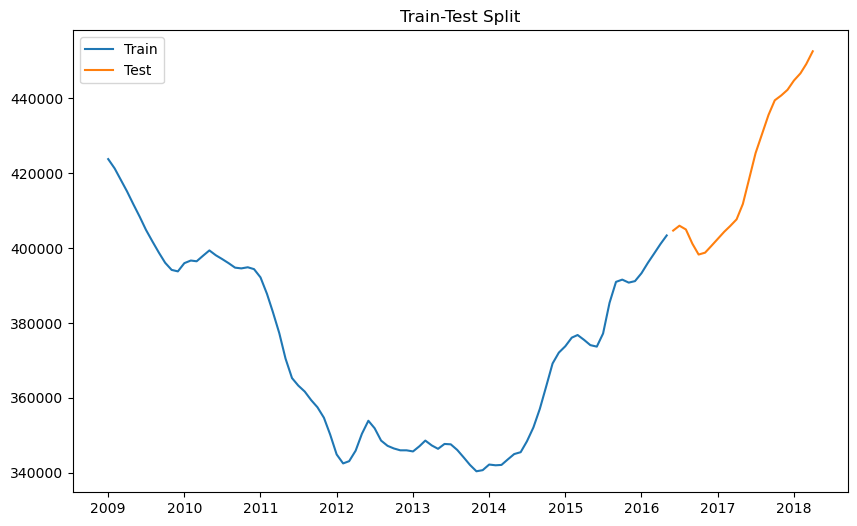

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [26]:
# Time Series Split on train
split=TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train Index: {train_ind}')
    print(f'Test Index: {val_ind}')

Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Test Index: [19 20 21 22 23 24 25 26 27 28 29 30 31 32]
Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Test Index: [33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Test Index: [47 48 49 50 51 52 53 54 55 56 57 58 59 60]
Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]
Test Index: [61 62 63 64 65 66 67 68 69 70 71 72 73 74]
Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71


# Auto Arima
We will use Auto Arima to automate the process of building ARIMA models by selecting the optimal parameters (p,d,q) through statistical tests and grid search. It determines the order of differencing needed to make the time series stationary and uses AIC to choose the best model. We also searches for seasonal parameters.

Instead of manually choosing the order of AR, MA, and seasonal components, I used auto_arima() to automatically select the best model parameters based on statistical tests like AIC (Akaike Information Criterion).
This ensures we’re using a model that balances complexity and accuracy, reducing the risk of overfitting. 

In [57]:
auto_model = pm.auto_arima(
    train,         
    start_p=0,             # Starting value of p (AR order)
    start_q=0,             # Starting value of q (MA order)
    test='adf',            # Unit root test to check stationarity (ADF test)
    max_p=5,               # Maximum value of p
    max_q=5,               # Maximum value of q
    m=1,                   # Number of periods in each season (1 for non-seasonal data)
    d=0,                   # Order of non-seasonal differencing
    seasonal=True,         # Whether to include seasonal components
    start_P=0,             # Starting value of P (seasonal AR order)
    start_Q=0,             # Starting value of Q (seasonal MA order)
    D=0,                   # Order of seasonal differencing
    trace=False,            # Whether to print progress messages
    error_action='ignore', # Action to take when an error occurs ('ignore' to suppress)
    suppress_warnings=True # Whether to suppress warnings
)

In [59]:
# Print the best AR, MA, and seasonal parameters
print("Best (p, d, q):", auto_model.order)
print("Best (P, D, Q):", auto_model.seasonal_order)

Best (p, d, q): (5, 0, 2)
Best (P, D, Q): (0, 0, 0, 0)


Best model:  ARIMA(2,0,3)

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9974      0.006    165.168      0.000       0.986       1.009
ar.L2          0.0003      0.007      0.050      0.960      -0.013       0.013
ma.L1          1.5392      0.185      8.327      0.000       1.177       1.901
ma.L2          0.8093      0.253      3.193      0.001       0.313       1.306
ma.L3         -0.0947      0.127     -0.744      0.457      -0.344       0.155
sigma2       9.54e+06   3.75e-09   2.55e+15      0.000    9.54e+06    9.54e+06


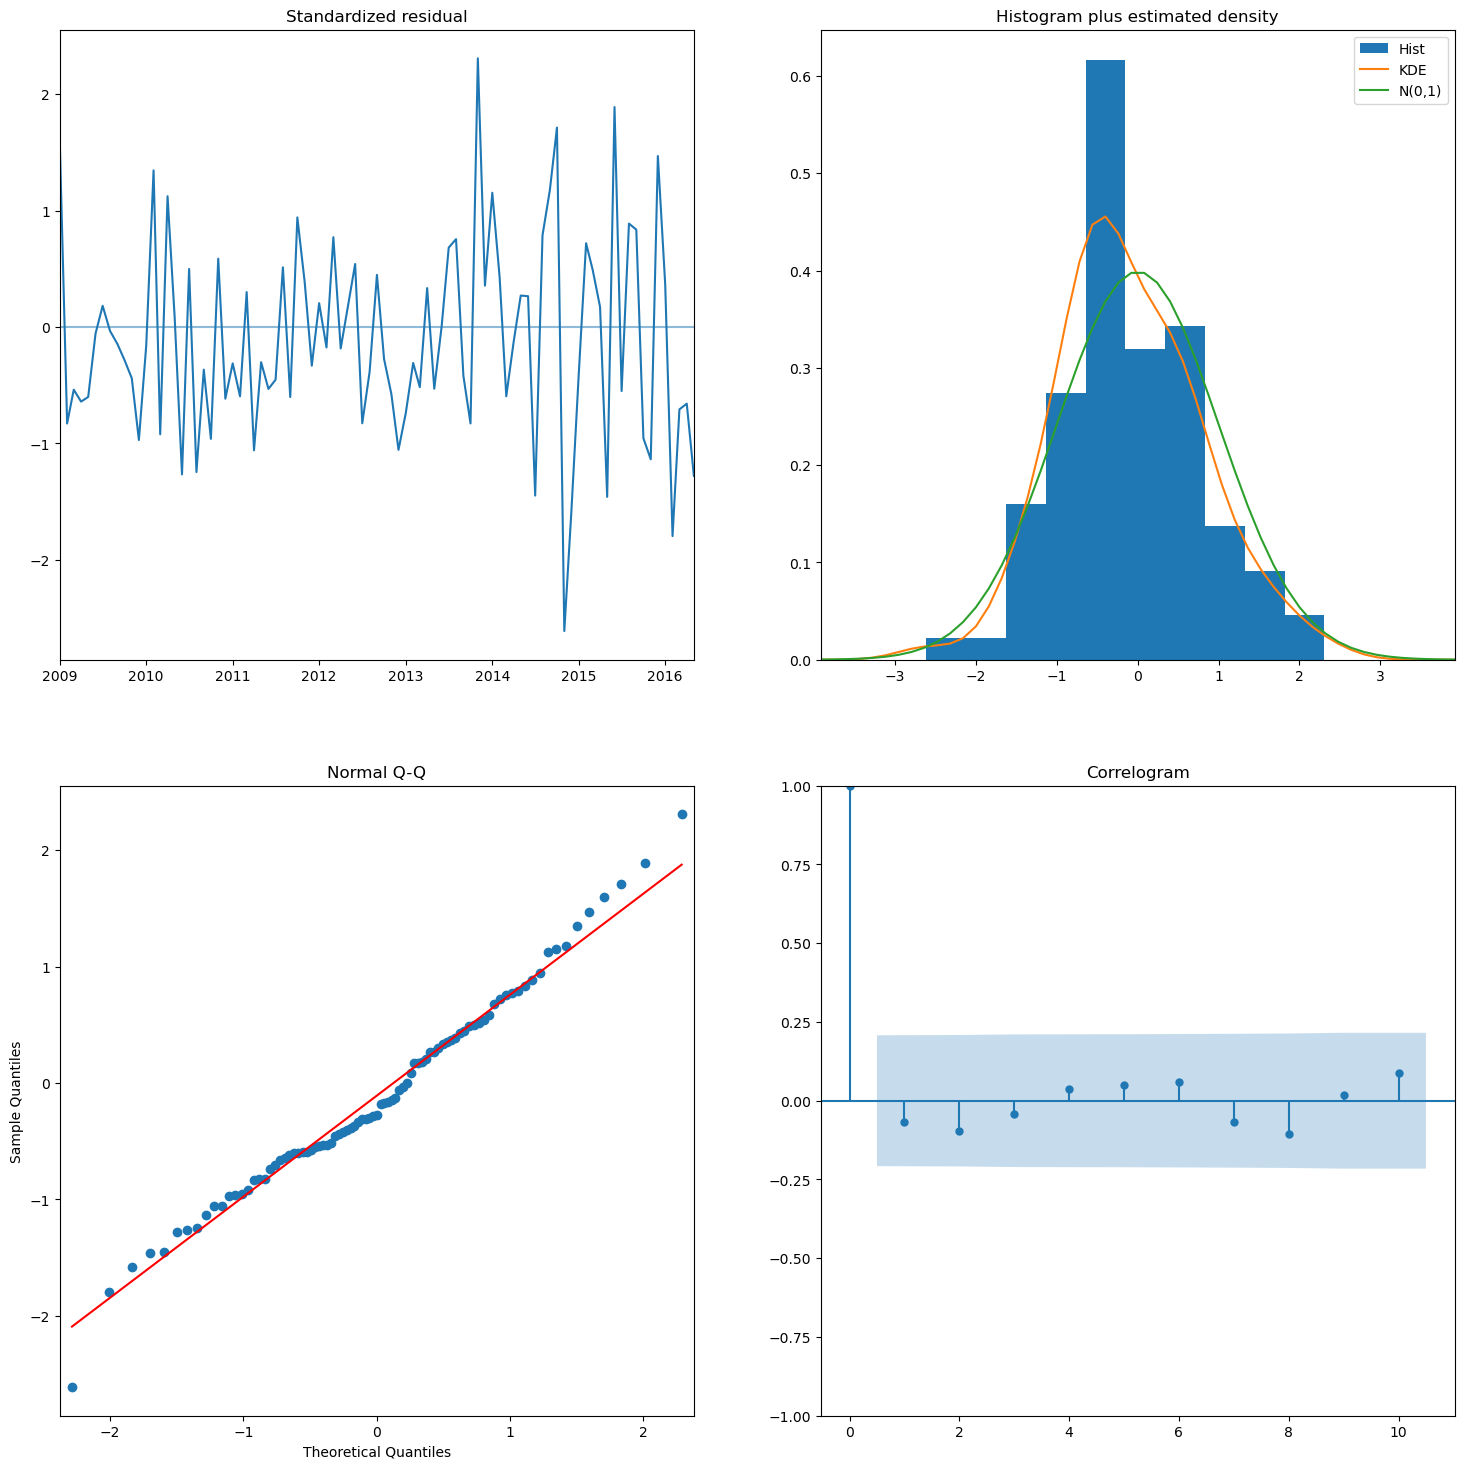

In [49]:
arima_model = sm.tsa.statespace.SARIMAX(train, 
                                        order=(2,0,3), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = arima_model.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

### Output Summary

1. Standardized Residuals: generally behave like white noise — randomly scattered, normally distributed, and uncorrelated — meaning the SARIMAX model seems to fit reasonably well.
2. Histogram plus KDE plot: the residuals roughly follow a normal distribution, though there’s a slight skew and some deviation in the tails.
3. Normal Q-Q plot: the points mostly lie along the red 45° line, suggesting the residuals are approximately normally distributed.
4. Correlogram (ACF plot of residuals): all lags fall within the blue confidence interval, meaning there’s no significant autocorrelation left in the residuals.


### Forecasting
Apply our model to forecast future prices

In [29]:
forecast_steps = 60  # 5 years * 12 months/year

In [30]:
forecast = output.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [31]:
forecast_dates = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_14292\3615039076.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')


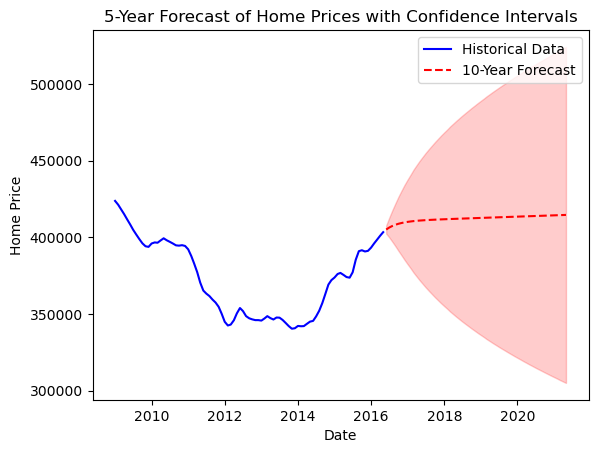

In [32]:
# Plot historical data
plt.plot(train.index, train, label='Historical Data', color='blue')

# Plot forecasts
plt.plot(forecast_dates, forecast_mean, label='10-Year Forecast', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='red', alpha=0.2)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.title('5-Year Forecast of Home Prices with Confidence Intervals')
plt.legend()

# Display the plot
plt.show()

## Applying model to the other Westchester zip codes
For each zipcode, we will find the optimal parameters for the model and forecast the home prices 5 years out. Then we will calculate the ROI each and take the 5 zipcodes with the highest ROI.

In [33]:
filtered_df

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,425400,430500,435600,439500,440800,442300,444800,446700,449200,452600
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,417400,419600,420200,419700,417200,413800,412000,412100,414400,416900
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,444400,447800,450600,450400,447500,445100,444500,444600,445400,445800
4579,61865,10566,Peekskill,NY,New York,Westchester,4580,143200.0,143500.0,143700.0,...,272300,272800,271800,270200,268500,269400,271800,274400,278400,283400
5849,61897,10703,Yonkers,NY,New York,Westchester,5850,163800.0,163500.0,163200.0,...,411200,413400,415400,417000,418400,419200,419900,419400,420300,422800
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,216500.0,217100.0,217800.0,...,496500,495600,498100,498900,493500,488200,486400,488500,494200,499100
6617,61866,10567,Cortlandt Manor,NY,New York,Westchester,6618,181200.0,180800.0,180300.0,...,374200,373600,375400,376600,375900,376400,378600,380600,382700,385100


In [34]:
# Create an array of only the Westchester zip codes
westchester_zipcodes = filtered_df['Zipcode'].unique()
westchester_zipcodes

array([10701, 10705, 10550, 10704, 10562, 10598, 10566, 10703, 10603,
       10567, 10589, 10553, 10523, 10547, 10588, 10537, 10526],
      dtype=int64)

In [35]:
# Initialize an empty dictionary to store filtered DataFrames
filtered_dfs = {}

# Iterate over each unique ZIP code
for zip_code in westchester_zipcodes:
    # Filter the DataFrame for the current ZIP code
    filtered_dfs[zip_code] = filtered_df[filtered_df['Zipcode'] == zip_code]

In [36]:
# Initialize an empty dictionary to store the melted DataFrames
melted_dfs = {}

# Iterate over each unique ZIP code
for zipcode in westchester_zipcodes:
    # Filter the DataFrame for the current ZIP code
    filtered_df_zipcode = filtered_df[filtered_df['Zipcode'] == zipcode]
    
    # Apply the melt_data function
    melted_df = melt_data(filtered_df_zipcode)
    
    # Convert 'time' to datetime and set it as the index
    melted_df['time'] = pd.to_datetime(melted_df['time'], errors='coerce')
    melted_df = melted_df[melted_df['time'] >= pd.to_datetime('2009-01-01')]
    melted_df.set_index('time', inplace=True)
    
    # Store the melted DataFrame in the dictionary with the ZIP code as the key
    melted_dfs[f'ts_{zipcode}'] = melted_df

In [37]:
melted_dfs

{'ts_10701':             HomePrice
 time                 
 2009-01-01   440600.0
 2009-02-01   436400.0
 2009-03-01   431100.0
 2009-04-01   425400.0
 2009-05-01   419600.0
 ...               ...
 2017-12-01   451400.0
 2018-01-01   454000.0
 2018-02-01   456500.0
 2018-03-01   458400.0
 2018-04-01   459800.0
 
 [112 rows x 1 columns],
 'ts_10705':             HomePrice
 time                 
 2009-01-01   440200.0
 2009-02-01   439300.0
 2009-03-01   438600.0
 2009-04-01   438700.0
 2009-05-01   438700.0
 ...               ...
 2017-12-01   474400.0
 2018-01-01   476500.0
 2018-02-01   475400.0
 2018-03-01   475600.0
 2018-04-01   477400.0
 
 [112 rows x 1 columns],
 'ts_10550':             HomePrice
 time                 
 2009-01-01        NaN
 2009-02-01        NaN
 2009-03-01        NaN
 2009-04-01        NaN
 2009-05-01        NaN
 ...               ...
 2017-12-01   299600.0
 2018-01-01   301600.0
 2018-02-01   304300.0
 2018-03-01   305000.0
 2018-04-01   304800.0
 
 [112 rows 

### Apply AutoARIMA to all zipcodes to Forecast future home prices
Now that we have a time series for each zip code, we will apply auto ARIMA to each of them to find the optimal parameters to forecast home prices 5 for the next 5 years.

In [61]:
# Initialize a dictionary to store forecasted data for plotting
forecasted_data = {}

# Initialize a dictionary to store ROI for each ZIP code
zip_predictions = {}

# Initialize a list to store the final results for the DataFrame
data_list = []

# Iterate over each key-value pair in the dictionary
for zipcode, ts in melted_dfs.items():
    # Ensure the DataFrame is sorted by time index
    ts = ts.sort_index()
    
    # Split data into train and test sets
    train_size = int(len(ts) * 0.8)
    train, test = ts.iloc[:train_size], ts.iloc[train_size:]
    
    # Auto ARIMA model on the training set without trace
    auto_model = pm.auto_arima(train['HomePrice'], start_p=0, start_q=0,
                               test='adf', max_p=5, max_q=5, m=1, d=0,
                               seasonal=True, start_P=0, start_Q=0, D=0,
                               trace=False,  # Suppresses stepwise output
                               error_action='ignore',
                               suppress_warnings=True, 
                               stepwise=True,
                               with_intercept=False)
   
    # Fit the SARIMAX model on the entire series
    arima_model = sm.tsa.statespace.SARIMAX(ts['HomePrice'], 
                                            order=auto_model.order, 
                                            seasonal_order=auto_model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model
    output = arima_model.fit(disp=False)
    
    # Forecast for the next 60 periods
    forecast = output.get_forecast(steps=60)
    prediction = forecast.conf_int()
    prediction['prediction'] = forecast.predicted_mean
    prediction.columns = ['lower', 'upper', 'prediction']
    
    # Store forecasted data for plotting
    forecast_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=60, freq='MS')
    forecast_df = pd.DataFrame({'HomePrice': prediction['prediction'].values}, index=forecast_dates)
    forecasted_data[zipcode] = forecast_df
    
    # Calculate ROI and add to the zip_predictions dictionary
    last_actual = ts['HomePrice'].iloc[-1]
    last_predicted = prediction['prediction'].iloc[-1]
    roi = (last_predicted - last_actual) / last_actual
    zip_predictions[zipcode] = roi
    
    # Add the data to the list for the DataFrame, including the best ARIMA model
    data_list.append([zipcode, last_actual, last_predicted, roi, auto_model.order, auto_model.seasonal_order])

# Create a DataFrame from the list
df = pd.DataFrame(data_list, columns=['Zipcode', 'Last_Actual_Price', 'Last_Predicted_Price', 'ROI', 'Best_ARIMA_Order', 'Best_Seasonal_Order'])

In [62]:
# Remove 'ts_' prefix from 'Zipcode' column
df['Zipcode'] = df['Zipcode'].str.removeprefix('ts_')
df

,Zipcode,Last_Actual_Price,Last_Predicted_Price,ROI,Best_ARIMA_Order,Best_Seasonal_Order
0,10701,459800.0,507382.118963,0.103484,"(2, 0, 1)","(0, 0, 0, 0)"
1,10705,477400.0,509793.818572,0.067855,"(3, 0, 2)","(0, 0, 0, 0)"
2,10550,304800.0,182673.841664,-0.400676,"(3, 0, 2)","(0, 0, 0, 0)"
3,10704,452600.0,498281.600827,0.100932,"(2, 0, 3)","(0, 0, 0, 0)"
4,10562,416900.0,408448.459207,-0.020272,"(2, 0, 2)","(0, 0, 0, 0)"
5,10598,445800.0,476349.843063,0.068528,"(2, 0, 3)","(0, 0, 0, 0)"
6,10566,283400.0,248781.857255,-0.122153,"(2, 0, 3)","(0, 0, 0, 0)"
7,10703,422800.0,446119.521588,0.055155,"(2, 0, 2)","(0, 0, 0, 0)"
8,10603,499100.0,509293.435517,0.020424,"(2, 0, 2)","(0, 0, 0, 0)"
9,10567,385100.0,388687.003970,0.009314,"(2, 0, 2)","(0, 0, 0, 0)"


### Visualize forecasts and ROI for each zipcode

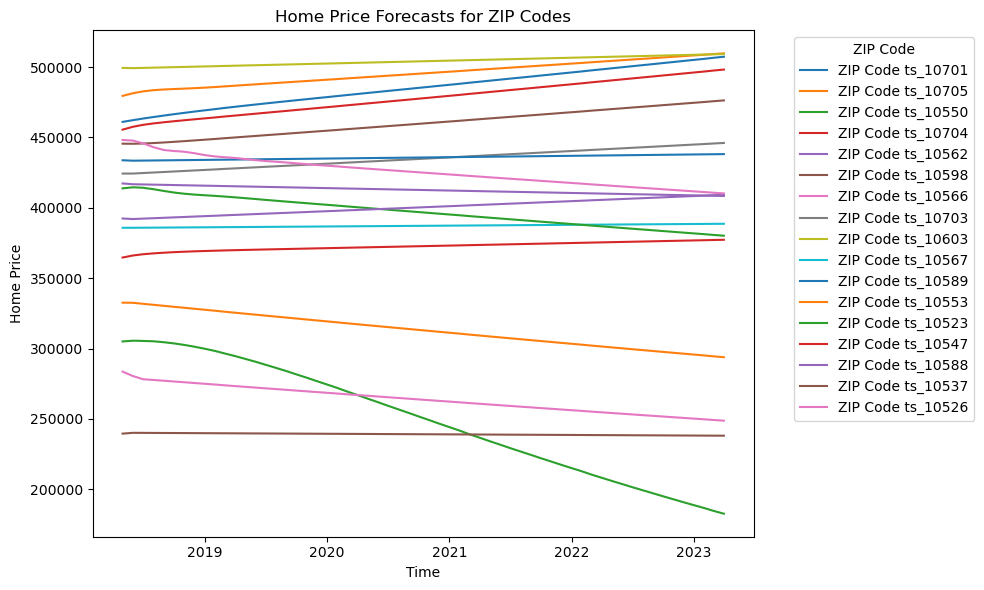

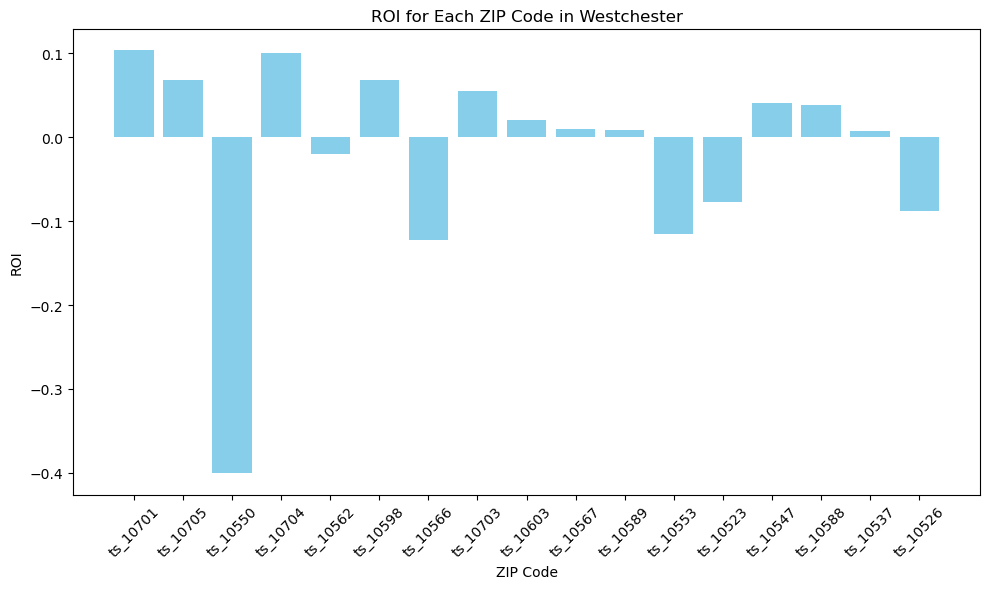

In [40]:
# Plot all forecasts on the same graph
plt.figure(figsize=(10, 6))
for zipcode, forecast_df in forecasted_data.items():
    plt.plot(forecast_df.index, forecast_df['HomePrice'], label=f'ZIP Code {zipcode}')

plt.xlabel('Time')
plt.ylabel('Home Price')
plt.title('Home Price Forecasts for ZIP Codes')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot ROI for each ZIP code
plt.figure(figsize=(10, 6))
plt.bar(zip_predictions.keys(), zip_predictions.values(), color='skyblue')
plt.xlabel('ZIP Code')
plt.ylabel('ROI')
plt.title('ROI for Each ZIP Code in Westchester')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualize home prices for top 5 zipcodes by ROI

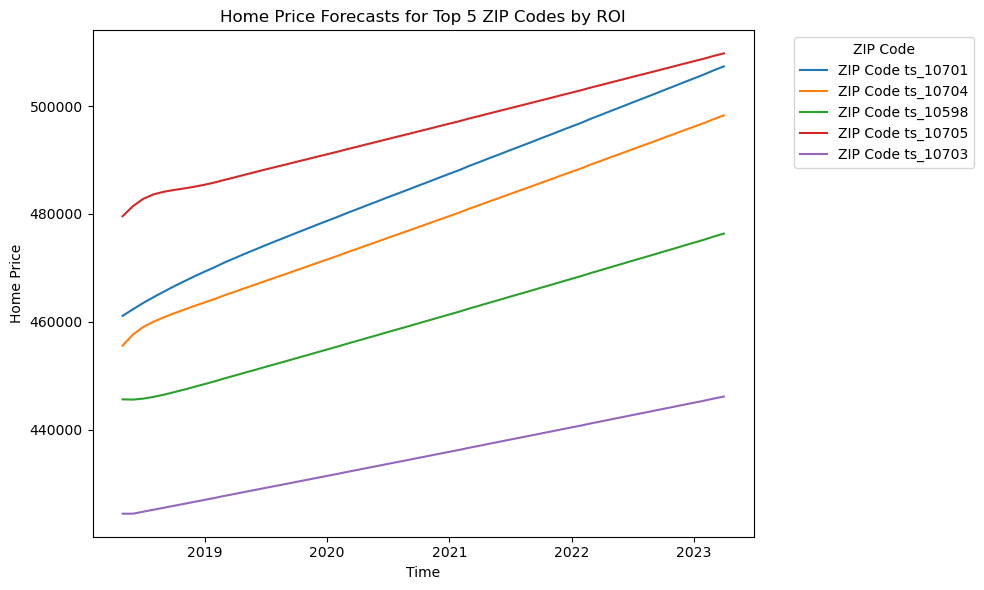

In [41]:
# Sort the ZIP codes by ROI in descending order and select the top 5
top_5_zipcodes = sorted(zip_predictions, key=zip_predictions.get, reverse=True)[:5]

# Plot the forecasts for the top 5 ZIP codes
plt.figure(figsize=(10, 6))
for zipcode in top_5_zipcodes:
    forecast_df = forecasted_data[zipcode]
    plt.plot(forecast_df.index, forecast_df['HomePrice'], label=f'ZIP Code {zipcode}')

plt.xlabel('Time')
plt.ylabel('Home Price')
plt.title('Home Price Forecasts for Top 5 ZIP Codes by ROI')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
top_5_df = df.sort_values(by='ROI', ascending=False).head(5)
top_5_df

,Zipcode,Last_Actual_Price,Last_Predicted_Price,ROI
0,10701,459800.0,507382.118963,0.103484
3,10704,452600.0,498281.600827,0.100932
5,10598,445800.0,476349.843063,0.068528
1,10705,477400.0,509793.818572,0.067855
7,10703,422800.0,446119.521588,0.055155


### Plot ROI for top 5 zip codes

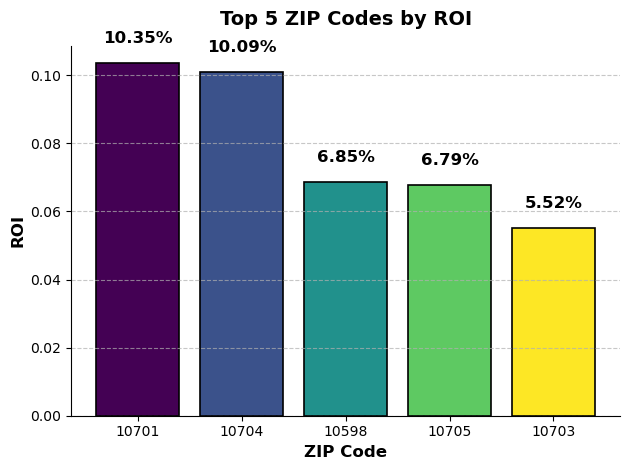

In [43]:
# Use viridis colormap and normalize based on the number of bars
colors = plt.cm.viridis(np.linspace(0, 1, len(top_5_df)))

# Create the bar plot with the colormap
bars = plt.bar(top_5_df['Zipcode'].astype(str), top_5_df['ROI'], color=colors, edgecolor='black', linewidth=1.2)

# Add labels and title
plt.xlabel('ZIP Code', fontsize=12, fontweight='bold')
plt.ylabel('ROI', fontsize=12, fontweight='bold')
plt.title('Top 5 ZIP Codes by ROI', fontsize=14, fontweight='bold', pad=15)

# Customize grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display ROI values above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f'{height:.2%}',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Adjust layout
plt.tight_layout()
plt.show()

In [44]:
# Ensure both 'Zipcode' columns are of type str
top_5_df['Zipcode'] = top_5_df['Zipcode'].astype(str)
filtered_df['Zipcode'] = filtered_df['Zipcode'].astype(str)

# Merge the DataFrames on 'Zipcode'
merged_df = pd.merge(top_5_df, filtered_df, on='Zipcode', how='left')

# Select the relevant columns for the final DataFrame
final_df = merged_df[['Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank',
                       'Last_Actual_Price', 'Last_Predicted_Price', 'ROI']]

# Display the final DataFrame
final_df

,Zipcode,City,State,Metro,CountyName,SizeRank,Last_Actual_Price,Last_Predicted_Price,ROI
0,10701,Yonkers,NY,New York,Westchester,275,459800.0,507382.118963,0.103484
1,10704,Yonkers,NY,New York,Westchester,3165,452600.0,498281.600827,0.100932
2,10598,Yorktown,NY,New York,Westchester,4137,445800.0,476349.843063,0.068528
3,10705,Yonkers,NY,New York,Westchester,2384,477400.0,509793.818572,0.067855
4,10703,Yonkers,NY,New York,Westchester,5850,422800.0,446119.521588,0.055155


## Recommendations

The top zipcodes by expected ROI over 5 years are:
1. 10701 - Yonkers
2. 10704 - Yonkers
3. 10598 - Yorktown
4. 10705 - Yonkers
5. 10703 - Yonkers

In [45]:
# Approximate latitude and longitude for each ZIP code
zip_coords = {
    '10701': [40.931, -73.890],
    '10705': [40.946, -73.865],
    '10704': [40.946, -73.902],
    '10598': [41.305, -73.866],
    '10703': [40.975, -73.880]}

In [46]:
# Create a base map centered roughly on Westchester County
m = folium.Map(location=[40.93, -73.90], zoom_start=11)

# Add markers for each ZIP code in the merged DataFrame
for idx, row in merged_df.iterrows():
    zipcode = row['Zipcode']
    lat, lon = zip_coords.get(zipcode, [40.93, -73.90])
    popup_text = f"{row['City']}, {row['State']} (Zip: {zipcode})<br>ROI: {row['ROI']:.2%}"
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color='blue', icon='home', prefix='fa')
    ).add_to(m)

# Save the map to an HTML file and display it
m.save('top_zipcodes_map.html')
m

# Conclusion

Based on the time series analysis and SARIMA modeling, we identified ZIP codes in Westchester County with homes priced at or below $500K and projected their home prices over the next 5 years. By calculating the expected ROI for each ZIP code, we can now highlight the top 5 areas that present the most promising investment opportunities for our client. Yonkers clearly emerged as a strong investment opportunity, with four out of the five recommended zip codes located within the city. This dominance can be attributed to several factors: proximity to New York City, ongoing infrastructure improvements, and a growing demand for more affordable housing options compared to NYC.

Best zip codes in Westchester and their optimal ARIMA parameters are:

* 10701: (2, 0, 1)
* 10705: (3, 0, 2)
* 10704: (2, 0, 3)
* 10598: (2, 0, 3)	
* 10703: (2, 0, 2)

## Next Steps

Enhance the Forecasting Model:

- Add exogenous variables (like interest rates, employment rates, and population growth) to further refine the forecast.
- Create model using Facebook’s Prophet and use it for comparison